## Conv4_3D_res_v3
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 32--32--32/32/128--64/64/256 filters
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard
from keras.utils import HDF5Matrix

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator


[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices()]

Using TensorFlow backend.


['CPU 256 Mb',
 'XLA_CPU 16384 Mb',
 'XLA_GPU 16384 Mb',
 'XLA_GPU 16384 Mb',
 'GPU 7518 Mb',
 'GPU 7621 Mb']

In [2]:
#from tensorflow.python.client import device_lib
# TensorFlow wizardry
#config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)
# adding a custom activation function
get_custom_objects().update({'swish': swish})


def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv3D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('swish')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv3D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv3D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('swish')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_3d_model_small(input_shape=(32,32,8,1)):
    
    X_input = Input(input_shape)

    X = Conv3D(32, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
    X = Conv3D(32, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
    X = MaxPooling3D(name='pool1')(X)
    #print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.3, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')
    #print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [64,64, 256], stage = 3, block='a')
    X = identity_block(X, 3, [64,64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64,64, 256], stage=3, block='c')
    X = MaxPooling3D(padding='same', name='pool3')(X)
    #print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

In [4]:
class Batch_data_generator(keras.utils.Sequence):
    #images and labels are expected to be HDF5 datasets
    def __init__(self, dataset=None, run_type='train', batch_size=256, n_batch=None, shuff=True):
        assert not (dataset is None)
        self.dataset = dataset
        self.batch_size = batch_size
        self.rtype = run_type
        self.batch_ids = np.array(list(self.dataset[self.rtype].keys()), dtype=int)
        if isinstance(n_batch,int): self.batch_ids = np.random.permutation(self.batch_ids)[:n_batch]
        self.shuffle = shuff

    def __len__(self):
        return len(self.batch_ids)
    
    def on_epoch_end(self):
        # to shuffle indices each epoch
        if self.shuffle:
            np.random.shuffle(self.batch_ids)

    def __getitem__(self, idx):
        idx = self.batch_ids[idx]
        batch_x = self.dataset[self.rtype+'/'+str(idx)+'/images'][...]
        batch_y = self.dataset[self.rtype+'/'+str(idx)+'/labels'][...]
        return batch_x[...,np.newaxis], batch_y
    
class Batch_data_augmentator(keras.utils.Sequence):
    #images and labels are expected to be HDF5 datasets
    def __init__(self, dataset=None, run_type='train', batch_size=256, n_batch=None, shuff=True):
        assert not (dataset is None)
        self.dataset = dataset
        self.batch_size = batch_size
        self.rtype = run_type
        self.batch_ids = np.array(list(self.dataset[self.rtype].keys()), dtype=int)
        if isinstance(n_batch,int): self.batch_ids = np.random.permutation(self.batch_ids)[:n_batch]
        self.shuffle = shuff
        self.aug_train = ImageDataGenerator(rotation_range=90, fill_mode='reflect', dtype=float)

    def __len__(self):
        return len(self.batch_ids)
    
    def on_epoch_end(self):
        # to shuffle indices each epoch
        if self.shuffle:
            np.random.shuffle(self.batch_ids)

    def __getitem__(self, idx):
        idx = self.batch_ids[idx]
        batch_x = self.dataset[self.rtype+'/'+str(idx)+'/images'][...]
        batch_y = self.dataset[self.rtype+'/'+str(idx)+'/labels'][...]
        params = self.aug_train.get_random_transform(batch_x.shape[1:])
        for i in range(batch_x.shape[0]):
            batch_x[i] = self.aug_train.apply_transform(batch_x[i], params)
        return batch_x[...,np.newaxis], batch_y

In [5]:
# Training 1 time, validating n_folds.
def rot_train(sig_names=None, bckg_names=None, N_ep=5, batch=256, n_fold=3, lr=1e-4, beta_1=0.95, beta_2=0.999, dset=None, verb=1, small_val=20):
    
    if not sig_names: sig_names = ['Carbon/30keV']
    if not bckg_names: bckg_names = ['fog']
    for s in sig_names:
        s_ = '-'.join(s.split('/'))
        for b in bckg_names:
            b_ = '-'.join(b.split('/'))
            #if '100keV' in s or '60keV' in s: continue
            
            N_tot, n_s = 0,0
            with h5py.File(dset+s_+'_'+b_+'.h5','r') as data_sb:
                im_shape = data_sb['train/1/images'].shape[1:]
                for k in data_sb['train'].keys():
                    n_s += np.sum(data_sb['train/'+k+'/labels'])
                    N_tot += len(data_sb['train/'+k+'/labels'])
                #X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
                #X_small_val, y_small_val = data_sb['val/images'][:small_val], data_sb['val/labels'][:small_val]
            #X_tr, y_tr = HDF5Matrix(dset+s_+'_'+b_+'.h5','train/images'), HDF5Matrix(dset+s_+'_'+b_+'.h5','train/labels')
            #X_val, y_val = HDF5Matrix(dset+s_+'_'+b_+'.h5','val/images'), HDF5Matrix(dset+s_+'_'+b_+'.h5','val/labels')
            #X_small_val, y_small_val = HDF5Matrix(dset+s_+'_'+b_+'.h5','val/images',end=small_val), HDF5Matrix(dset+s_+'_'+b_+'.h5','val/labels',end=small_val)

            print('\n\tFor training on '+s+' vs '+b)
            print('Number of '+s+' samples\t',n_s)
            print('Number of '+b+' samples\t',N_tot-n_s)

            #print('Number of validation samples',X_small_val.shape[0])

            K.clear_session()
            nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
            print('\nMODEL '+s+' vs '+b)
            fold = datetime.now()
            gc.collect()
            
            train_gen = Batch_data_augmentator(dataset=h5py.File(dset+s_+'_'+b_+'.h5','r'),run_type='train',batch_size=batch)
            small_val_gen = Batch_data_generator(dataset=h5py.File(dset+s_+'_'+b_+'.h5','r'),run_type='val',batch_size=batch,n_batch=small_val, shuff=False)
            with tf.device('/cpu:0'):
                model_cpu = conv_res_3d_model_small(input_shape=(*im_shape, 1))
            conv4_3d_res = multi_gpu_model(model_cpu, gpus=2)
            conv4_3d_res.compile(optimizer=nadamka, loss='binary_crossentropy')
            #t_board = TensorBoard(log_dir='./logs/carbon_'+b.split('/')[0]+'/rot/'+s_+'_'+b_, histogram_freq=0, batch_size=batch, write_graph=False,
            #                      write_grads=False, write_images=False, update_freq='epoch')
            #print('\t\tTrain starts')
            hist = conv4_3d_res.fit_generator(train_gen, steps_per_epoch=N_tot*2//batch, epochs=N_ep,# callbacks=[t_board],
                                              #max_queue_size=4, workers=2, use_multiprocessing=True,
                                              validation_data=small_val_gen, verbose=verb)
            loss, valoss = list(hist.history['loss']), list(hist.history['val_loss'])
            hist_tmp = hist
            while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-5:]):
                print('\t\tval loss fluctuation:',np.around(hist.history['loss'][-1],decimals=4),'bigger, than last 5 epochs median:',np.around(np.median(hist.history['val_loss'][-5:]),decimals=4))
                print('\n\t\tperforming additional training:')
                hist_tmp = conv4_3d_res.fit_generator(train_gen, steps_per_epoch=N_tot*2//batch, epochs=5,
                                                      #max_queue_size=4, workers=2, use_multiprocessing=True,
                                                      validation_data=small_val_gen, verbose=verb)
                loss += list(hist_tmp.history['loss']); valoss += list(hist_tmp.history['val_loss'])
            
            print('\tmodel training time ', datetime.now()-fold)
            print('\ttraining loss: ',np.around(loss[-1],decimals=4),
                  '\t validation loss: ',np.around(valoss[-1],decimals=4))
                  #'\tROC AUC: ',np.around(hist_roc.val_aucs[-1],decimals=4))
            print('')
            del train_gen, small_val_gen
            gc.collect()

            if not os.path.exists(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/'):
                os.makedirs(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/')
            #np.savetxt('outputs/conv4_3d_res/v3/rot/'+s_+'_'+b_+'_roc_auc_'+str(N_ep)+'.txt', hist_roc.val_aucs)
            np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/e'+str(N_ep)+'_'+s_+'_'+b_+'_loss_train.txt', loss)
            np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/e'+str(N_ep)+'_'+s_+'_'+b_+'_loss_val.txt', valoss) 
            if not os.path.exists(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/'):
                os.makedirs(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/')
            conv4_3d_res.save(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/conv4_3d_res_'+s_+'_'+b_+'_batch.h5')

            print('Predicting for validation')
            fold = datetime.now()
            y_val = []
            n_sval, N_val = 0,0
            with h5py.File(dset+s_+'_'+b_+'.h5','r') as data_sb:
                im_shape = data_sb['val/1/images'].shape[1:]
                for k in data_sb['val'].keys():
                    n_sval += np.sum(data_sb['val/'+k+'/labels'])
                    N_val += len(data_sb['val/'+k+'/labels'])
                    y_val += list(data_sb['val/'+k+'/labels'][...])
            val_gen = Batch_data_generator(dataset=h5py.File(dset+s_+'_'+b_+'.h5','r'),run_type='val',batch_size=batch, shuff=False)
            print('\tNumber of validation samples',N_val, '(',n_sval,'vs',N_val-n_sval,')')
            preds = conv4_3d_res.predict_generator(val_gen, verbose=verb)#, workers=5, max_queue_size=10, use_multiprocessing=True)
            #preds = conv4_3d_res.predict(X_val[...,np.newaxis], batch_size=batch, verbose=verb)
            #print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds))
            preds = np.vstack((np.squeeze(preds),np.array(y_val))).T
            if not os.path.exists(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'):
                os.makedirs(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/')
            np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'+'e'+str(N_ep)+'_'+s_+'_'+b_+'_batch.txt',preds)
            print('\tvalidation time ', datetime.now()-fold)
            del val_gen, y_val#, t_board#, X_val
            del hist, conv4_3d_res, preds#, hist_roc
            gc.collect()
    return True

In [6]:
gc.collect()

7

In [7]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
sig_names = ['Carbon/100keV']
bckg_names = ['beta']
#with h5py.File(dset+'dataset_phys_clean_9pol.h5','r') as df:
#    sig_names = ['Carbon/'+s for s in df['Carbon'].keys()]
#    bckg_names += ['gamma/'+s for s in df['gamma'].keys()]

lr = 1e-3; beta_1 = 0.95; beta_2 = 0.999
N_ep = 50; batch = 512; n_fold = 4; small_val = 20
print('Training for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',lr,'\tbeta_1 =',beta_1,'\tbeta_2 =',beta_2,'\n')
print('The amount of validation data used during training is',small_val*batch)
start = datetime.now()
rot_train(sig_names=sig_names, bckg_names=bckg_names, N_ep=N_ep, batch=batch, n_fold=n_fold, lr=lr, beta_1=beta_1, beta_2=beta_2, dset=dset+'ready-to-multi-batch/', verb=1, small_val=small_val)
print('\nTotal training time ', datetime.now()-start)

Training for  50  epochs with batch_size = 512
The optimizer is Nadam:
	initial lr = 0.001 	beta_1 = 0.95 	beta_2 = 0.999 

The amount of validation data used during training is 10240

	For training on Carbon/100keV vs beta
Number of Carbon/100keV samples	 202671
Number of beta samples	 185076
Instructions for updating:
Colocations handled automatically by placer.

MODEL Carbon/100keV vs beta
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1514/1514 [==============================] - 844s 557ms/step - loss: 0.2987 - val_loss: 0.2577
Epoch 2/50
1514/1514 [==============================] - 755s 499ms/step - loss: 0.1189 - val_loss: 1.1572
Epoch 3/50
1514/1514 [==============================] - 754s 498ms/step - loss: 0.0812 - val_loss: 0.0962
Epoch 4/50
1514/1514 [==============================] - 755s 499ms/step - loss: 0.0682 - val_loss: 0.1237
Epoch 5/50
1514/1

In [9]:
s, b = 'Carbon/100keV','beta'
s_ = '-'.join(s.split('/'))
b_ = '-'.join(b.split('/'))
print('Predicting for validation')
fold = datetime.now()

with tf.device('/cpu:0'):
    model_cpu = load_model(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/conv4_3d_res_'+s_+'_'+b_+'.h5',custom_objects={'swish':swish})
conv4_3d_res = multi_gpu_model(model_cpu, gpus=2)
y_val = []
n_sval, N_val = 0,0
with h5py.File(dset+'ready-to-multi-batch/'+s_+'_'+b_+'.h5','r') as data_sb:
    im_shape = data_sb['val/1/images'].shape[1:]
    for k in data_sb['val'].keys():
        n_sval += np.sum(data_sb['val/'+k+'/labels'])
        N_val += len(data_sb['val/'+k+'/labels'])
        y_val += list(data_sb['val/'+k+'/labels'][...])
val_gen = Batch_data_generator(dataset=h5py.File(dset+'ready-to-multi-batch/'+s_+'_'+b_+'.h5','r'),run_type='val',batch_size=batch, shuff=False)
print('\tNumber of validation samples',N_val, '(',n_sval,'vs',N_val-n_sval,')')
preds = conv4_3d_res.predict_generator(val_gen, verbose=1)#, workers=5, max_queue_size=10, use_multiprocessing=True)
#preds = conv4_3d_res.predict(X_val[...,np.newaxis], batch_size=batch, verbose=verb)
#print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds))
preds = np.vstack((np.squeeze(preds),np.array(y_val))).T
if not os.path.exists(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'):
    os.makedirs(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/')
np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'+'e'+str(N_ep)+'_'+s_+'_'+b_+'.txt',preds)
print('\tvalidation time ', datetime.now()-fold)
del val_gen, y_val
del conv4_3d_res, preds#, hist_roc
gc.collect()

Predicting for validation
	Number of validation samples 258499 ( 135114 vs 123385 )
505/505 [==============================] - 72s 143ms/step
	validation time  0:01:54.335449


105

In [ ]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
sig_names = ['Carbon/100keV']
bckg_names = ['beta']
#with h5py.File(dset+'dataset_phys_clean_9pol.h5','r') as df:
#    sig_names = ['Carbon/'+s for s in df['Carbon'].keys()]
#    bckg_names += ['gamma/'+s for s in df['gamma'].keys()]

lr = 1e-3; beta_1 = 0.95; beta_2 = 0.999
N_ep = 50; batch = 256; n_fold = 4; small_val = 10000
print('Training for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',lr,'\tbeta_1 =',beta_1,'\tbeta_2 =',beta_2,'\n')
print('The amount of validation data used during training is',small_val)
start = datetime.now()
rot_train(sig_names=sig_names, bckg_names=bckg_names, N_ep=N_ep, batch=batch, n_fold=n_fold, lr=lr, beta_1=beta_1, beta_2=beta_2, dset=dset+'ready-to-float/', verb=1, small_val=small_val)
print('\nTotal training time ', datetime.now()-start)

Training for  50  epochs with batch_size = 256
The optimizer is Nadam:
	initial lr = 0.001 	beta_1 = 0.95 	beta_2 = 0.999 

The amount of validation data used during training is 10000

	For training on Carbon/100keV vs beta
Number of Carbon/100keV samples	 405343
Number of beta samples	 185076

MODEL Carbon/100keV vs beta
Epoch 1/50
4612/4612 [==============================] - 1409s 306ms/step - loss: 0.1696 - val_loss: 0.6913
Epoch 2/50
4612/4612 [==============================] - 1407s 305ms/step - loss: 0.0699 - val_loss: 1.3729
Epoch 3/50
4612/4612 [==============================] - 1408s 305ms/step - loss: 0.0560 - val_loss: 0.1448
Epoch 4/50
4612/4612 [==============================] - 1408s 305ms/step - loss: 0.0505 - val_loss: 0.1754
Epoch 5/50
4612/4612 [==============================] - 1407s 305ms/step - loss: 0.0471 - val_loss: 0.2245
Epoch 6/50
4612/4612 [==============================] - 1407s 305ms/step - loss: 0.0444 - val_loss: 0.1528
Epoch 7/50
4612/4612 [============

In [ ]:
gc.collect()

In [14]:
# Training 1 time, validating n_folds.
def rot_dotrain(sig_names=None, bckg_names=None, N_ep=5, N_do=5, batch=256, dset=None, verb=1, small_val=10000):
    
    if not sig_names: sig_names = ['Carbon/30keV']
    if not bckg_names: bckg_names = ['fog']
    for s in sig_names:
        s_ = '-'.join(s.split('/'))
        for b in bckg_names:
            b_ = '-'.join(b.split('/'))
            with h5py.File(dset+s_+'_'+b_+'.h5','r') as data_sb:
                X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
                X_small_val, y_small_val = data_sb['val/images'][:small_val], data_sb['val/labels'][:small_val]

            print('\n\tFor training on '+s+' vs '+b)
            print('Number of '+s+' samples\t',np.sum(y_tr))
            print('Number of '+b+' samples\t',X_tr.shape[0]-np.sum(y_tr))

            K.clear_session()
            #nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
            print('\nMODEL '+s+' vs '+b)
            fold = datetime.now()
            gc.collect()

            train_gen = Batch_data_augmentator(X_tr,y_tr,batch_size=batch)
            small_val_gen = Batch_data_generator(X_small_val,y_small_val,batch_size=batch, shuff=False)
            conv4_3d_res = load_model(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/conv4_3d_res_'+s_+'_'+b_+'.h5', custom_objects={'swish':swish})
            hist = conv4_3d_res.fit_generator(train_gen, steps_per_epoch=X_tr.shape[0]*2//batch, epochs=N_do,# callbacks=[t_board],
                                              #max_queue_size=4, workers=2, use_multiprocessing=True,
                                              validation_data=small_val_gen, verbose=verb)
            print('\tmodel training time ', datetime.now()-fold)
            print('\ttraining loss: ',np.around(hist.history['loss'][-1],decimals=4),
                  '\t validation loss: ',np.around(hist.history['val_loss'][-1],decimals=4))
                  #'\tROC AUC: ',np.around(hist_roc.val_aucs[-1],decimals=4))
            print('')
            del X_tr, X_small_val, y_tr, y_small_val, train_gen, small_val_gen
            gc.collect()

            if not os.path.exists(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/'):
                os.makedirs(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/')
            #np.savetxt('outputs/conv4_3d_res/v3/rot/'+s_+'_'+b_+'_roc_auc_'+str(N_ep)+'.txt', hist_roc.val_aucs)
            #np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/e'+str(N_ep)+'_'+s_+'_'+b_+'_loss_train.txt', hist.history['loss'])
            #np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/rot/e'+str(N_ep)+'_'+s_+'_'+b_+'_loss_val.txt', hist.history['val_loss']) 
            if not os.path.exists(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/'):
                os.makedirs(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/')
            conv4_3d_res.save(b.split('/')[0]+'/networks/res_v3/e'+str(N_ep)+'/rot/conv4_3d_res_'+s_+'_'+b_+'.h5')

            print('Predicting for validation')
            fold = datetime.now()
            with h5py.File(dset+s_+'_'+b_+'.h5','r') as data_sb:
                X_val, y_val = data_sb['val/images'][...], data_sb['val/labels'][...]
            #val_gen = Batch_data_generator(X_val,y_val,batch_size=batch, shuff=False)
            print('\tNumber of validation samples',X_val.shape[0])
            #preds = conv4_3d_res.predict_generator(val_gen, workers=5, max_queue_size=10, use_multiprocessing=True, verbose=verb)
            preds = conv4_3d_res.predict(X_val[...,np.newaxis], batch_size=batch, verbose=verb)
            #print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds))
            preds = np.vstack((np.squeeze(preds),y_val[...])).T
            if not os.path.exists(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'):
                os.makedirs(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/')
            np.savetxt(b.split('/')[0]+'/outputs/conv4_3d_res/v3/preds/rot/'+'e'+str(N_ep)+'_'+s_+'_'+b_+'.txt',preds)
            print('\tvalidation time ', datetime.now()-fold)
            del X_val, y_val#, t_board#, val_gen
            del hist, conv4_3d_res, preds#, hist_roc
            gc.collect()
    return True

In [15]:
start = datetime.now()
rot_dotrain(sig_names=sig_names, bckg_names=bckg_names, N_ep=N_ep, N_do=5, batch=batch, dset=dset+'ready-to-float/', verb=1, small_val=small_val)
print('\nTotal training time ', datetime.now()-start)


	For training on Carbon/60keV vs beta
Number of Carbon/60keV samples	 168576
Number of beta samples	 185076

MODEL Carbon/60keV vs beta
Epoch 1/5
2762/2762 [==============================] - 852s 309ms/step - loss: 0.0280 - val_loss: 0.0992
Epoch 2/5
2762/2762 [==============================] - 844s 306ms/step - loss: 0.0278 - val_loss: 0.0574
Epoch 3/5
2762/2762 [==============================] - 844s 305ms/step - loss: 0.0275 - val_loss: 0.0457
Epoch 4/5
2762/2762 [==============================] - 860s 311ms/step - loss: 0.0274 - val_loss: 0.2335
Epoch 5/5
2762/2762 [==============================] - 844s 306ms/step - loss: 0.0273 - val_loss: 0.0413
	model training time  1:11:01.228651
	training loss:  0.0273 	 validation loss:  0.0413

Predicting for validation
	Number of validation samples 235769
235769/235769 [==============================] - 96s 408us/step
	validation time  0:03:01.756414


UnboundLocalError: local variable 't_board' referenced before assignment

In [11]:
load_s = []
for n in class_names:
    load_s += [(n,str(i)) for i in range(1,n_fold+1)]
tr_loss, val_loss, hist_roc = {},{},{}
for s, p in load_s:
    hist_roc[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_roc_auc_'+str(N_ep)+'.txt')
    tr_loss[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_loss_train_'+str(N_ep)+'.txt')
    val_loss[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_loss_val_'+str(N_ep)+'.txt')

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


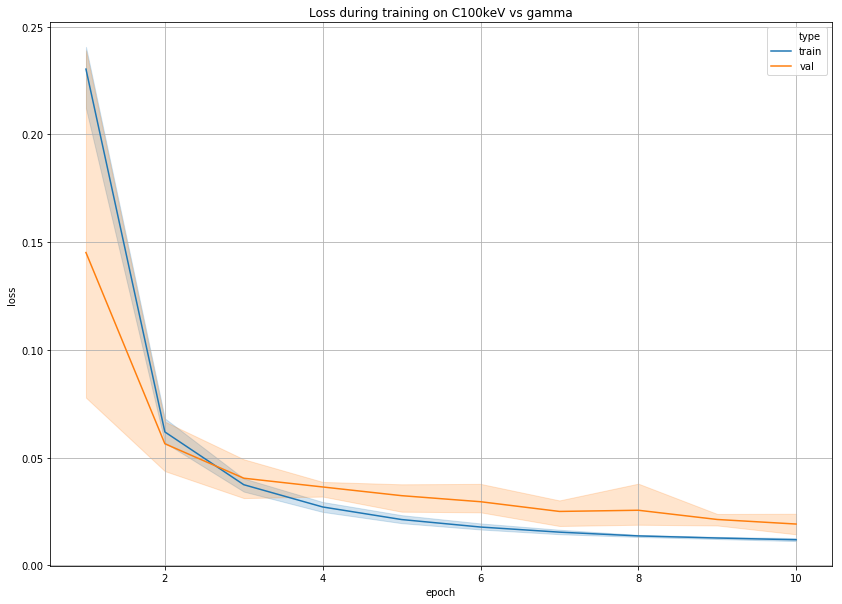

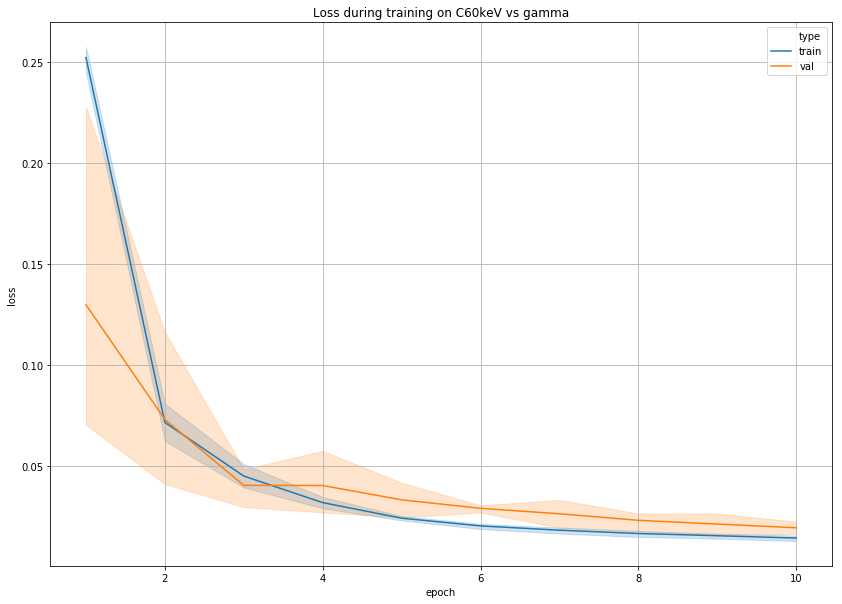

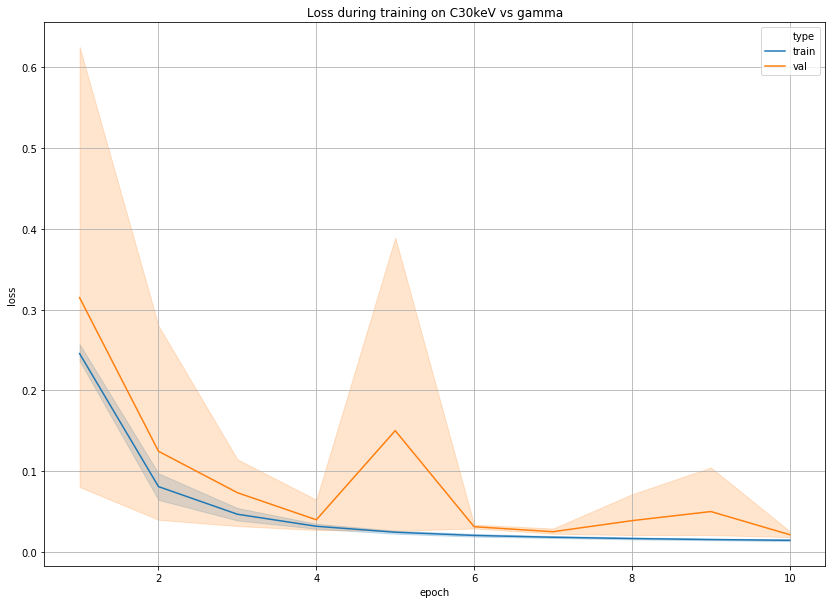

In [14]:
loss = {}
loss['epoch'], loss['type'], loss['loss'], loss['class'] = [],[],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        e = 1
        for l, vl in zip(tr_loss[s],val_loss[s]):
            loss['epoch'].append(e); loss['type'].append('train'); loss['loss'].append(l); loss['class'].append(n)
            loss['epoch'].append(e); loss['type'].append('val'); loss['loss'].append(vl); loss['class'].append(n)
            e += 1
loss = pd.DataFrame(data=loss)

for n in class_names:
    plt.figure(figsize=(14,10))
    sns.lineplot(x='epoch',y='loss',hue='type', data=loss[loss['class']==n])
    plt.grid()
    plt.title('Loss during training on '+n+' vs gamma')
    plt.show()

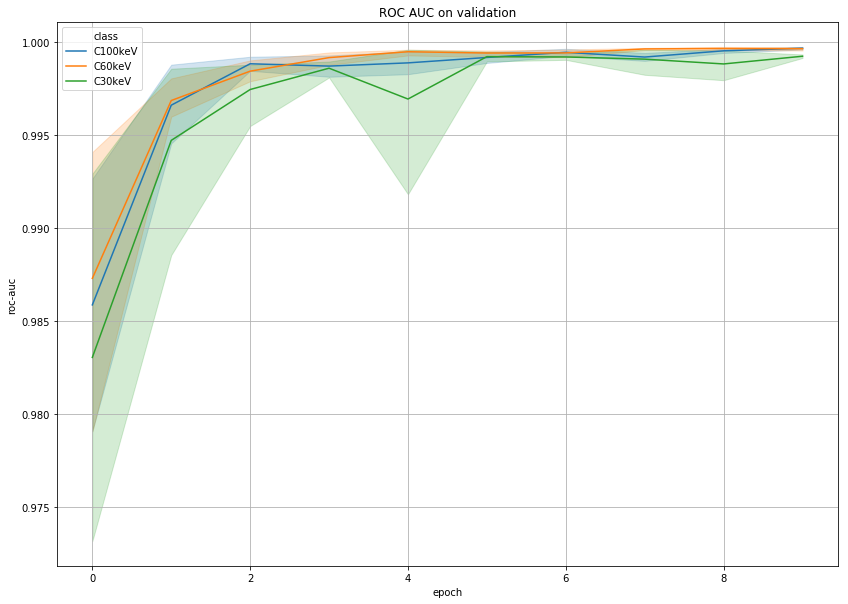

In [15]:
aucs = {}
aucs['epoch'], aucs['roc-auc'], aucs['class'] = [],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        for e, au in enumerate(hist_roc[s]):
            aucs['epoch'].append(e); aucs['roc-auc'].append(au); aucs['class'].append(n)
aucs = pd.DataFrame(data=aucs)

plt.figure(figsize=(14,10))
sns.lineplot(x='epoch',y='roc-auc', hue='class', data=aucs)
plt.grid()
_ = plt.title('ROC AUC on validation')

In [12]:
%whos

Variable                  Type        Data/Info
-----------------------------------------------
Activation                type        <class 'keras.layers.core.Activation'>
Add                       type        <class 'keras.layers.merge.Add'>
BatchNormalization        type        <class 'keras.layers.norm<...>tion.BatchNormalization'>
Batch_data_augmentator    type        <class '__main__.Batch_data_augmentator'>
Batch_data_generator      type        <class '__main__.Batch_data_generator'>
Concatenate               type        <class 'keras.layers.merge.Concatenate'>
Conv2D                    type        <class 'keras.layers.convolutional.Conv2D'>
Conv3D                    type        <class 'keras.layers.convolutional.Conv3D'>
Dense                     type        <class 'keras.layers.core.Dense'>
Dropout                   type        <class 'keras.layers.core.Dropout'>
Flatten                   type        <class 'keras.layers.core.Flatten'>
HDF5Matrix                type        <cl

In [5]:
_ = '''X, y, shuffs = {},{},{}
conv4_3d_res, hist_roc, hist, t_board, preds = {},{},{},{},{}
class_names = ['C60keV']#, 'C60keV', 'C30keV']
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'
lr = 1e-4; beta_1 = 0.95; beta_2 = 0.999
N_ep = 5; batch = 256; i=0; n_fold = 3
load_s = []
for n in class_names:
    load_s += [(n,str(i)) for i in range(1,n_fold+1)]
print('Training in ',n_fold,' folds for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',lr,'\tbeta_1 =',beta_1,'\tbeta_2 =',beta_2,'\n')

start = datetime.now()
#if os.path.exists('logs/carbon_fog/rot'): shutil.rmtree('logs/carbon_fog/rot')
for s, p in load_s:
    if not s in X.keys():
        print('\n\tFor validation on '+s+' vs fog')
        X[s], y[s], shuffs[s] = load_data_v2(classes={'s_'+s:'full', 'b_fog':'full'}, tr_val_test=[False,True,False],
                                             im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1, stratify=True)
        i=0; print('')
    K.clear_session()
    nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    i+=1; print('FOLD '+str(i)+':\t'+s+' part '+p+'/'+str(n_fold)+' vs fog part '+p+'/'+str(n_fold))
    fold = datetime.now()
    X_tr, y_tr, shuffs_tr = load_data_v2(classes={'s_'+s:p, 'b_fog':p}, n_folds=n_fold, tr_val_test=[True,False,False],
                                               im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1, ddd=False, stratify=True)
    gc.collect()
    aug_train = ImageDataGenerator(rotation_range=90, fill_mode='reflect', dtype=float)
    conv4_3d_res[s+p] = conv_res_3d_model(input_shape=(*X_tr['/images/train'].shape[1:], 1))
    conv4_3d_res[s+p].compile(optimizer=nadamka, loss='binary_crossentropy')
    hist_roc[s+p] = call_roc_hist()
    t_board = TensorBoard(log_dir='./logs/carbon_fog/rot/'+s+'_'+p, histogram_freq=2, batch_size=batch, write_graph=False,
                          write_grads=True, write_images=False, update_freq='batch')
    hist[s+p] = conv4_3d_res[s+p].fit_generator(train_gen(aug_train.flow(X_tr['/images/train'], y_tr['/images/train'],
                                                                         batch_size=batch)),
                                                steps_per_epoch=X_tr['/images/train'].shape[0]*2//batch, epochs=N_ep,
                                                callbacks=[hist_roc[s+p], t_board],
                                                validation_data=(X[s]['/images/val'],y[s]['/images/val']), verbose=1)
    print('\tfold training time ', datetime.now()-fold)
    print('\ttraining loss: ',np.around(hist[s+p].history['loss'][-1],decimals=4),
          '\t validation loss: ',np.around(hist[s+p].history['val_loss'][-1],decimals=4),
          '\tROC AUC: ',np.around(hist_roc[s+p].val_aucs[-1],decimals=4))
    print('')
    
    if not os.path.exists('outputs/conv4_3d_res/v2/rot/'):
        os.makedirs('outputs/conv4_3d_res/v2/rot/')
    np.savetxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_roc_auc_'+str(N_ep)+'.txt', hist_roc[s+p].val_aucs)
    np.savetxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_loss_train_'+str(N_ep)+'.txt', hist[s+p].history['loss'])
    np.savetxt('outputs/conv4_3d_res/v2/rot/'+s+'-'+p+'_loss_val_'+str(N_ep)+'.txt', hist[s+p].history['val_loss']) 
    if not os.path.exists('networks/res_v2/e'+str(N_ep)+'/rot/'):
        os.makedirs('networks/res_v2/e'+str(N_ep)+'/rot/')
    conv4_3d_res[s+p].save('networks/res_v2/e'+str(N_ep)+'/rot/conv4_3d_res_'+s+'-'+p+'.h5')
    
    for n in class_names:
        preds[n+'_'+s+'-'+p] = conv4_3d_res[s+p].predict(X[n]['/images/val'], batch_size=batch, verbose=0)
        print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds[n+'_'+s+'-'+p]))
        preds[n+'_'+s+'-'+p] = np.vstack((np.squeeze(preds[n+'_'+s+'-'+p]),y[n]['/images/val'])).T
        if not os.path.exists('outputs/conv4_3d_res/v2/preds/rot/'):
            os.makedirs('outputs/conv4_3d_res/v2/preds/rot/')
        np.savetxt('outputs/conv4_3d_res/v2/preds/rot/'+'e'+str(N_ep)+'_'+n+'_'+s+'-'+p+'.txt',preds[n+'_'+s+'-'+p])
    X_tr, y_tr, shuffs_tr, aug_train = None,None,None,None
    gc.collect()
print('\nTotal training time ', datetime.now()-start)'''

In [5]:
_='''# Training 1 time, validating n_folds.
def full_train(sig_names=None, bckg_names=None, N_ep=5, batch=256, n_fold=3, lr=1e-4, beta_1=0.95, beta_2=0.999, dset=None, verb=1):
    i=0
    if not sig_names: sig_names = ['Carbon/30keV']
    if not bckg_names: bckg_names = ['fog']
    load_s = []
    for n in sig_names:
        load_s += [(n,str(i)) for i in range(1,n_fold+1)]
    X, y, shuffs = {},{},{}
    for s in sig_names:
        for b in bckg_names:
            s_ = '-'.join(s.split('/'))
            b_ = '-'.join(b.split('/'))
            print('\n\tFor training on '+s+' vs '+b)
            X_tr, y_tr, _ = load_data_v3(classes={'s_'+s:'full', 'b_'+b:'full'}, tr_val_test=[True,False,False],
                                                     im_ft=[True,False], path_h5=dset, verbose=1, ddd=False, stratify=False)
            print('\nFor validation in '+str(n_fold)+' folds')
            for i in range(1,n_fold+1):
                X[s+'_'+b+'-'+str(i)], y[s+'_'+b+'-'+str(i)], _ = load_data_v3(classes={'s_'+s:str(i), 'b_'+b:str(i)}, n_folds=n_fold,
                                                                               tr_val_test=[False,True,False], im_ft=[True,False], path_h5=dset, verbose=2, stratify=True)
            K.clear_session()
            nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
            print('\nMODEL '+s+' vs '+b)
            fold = datetime.now()
            gc.collect()
            aug_train = ImageDataGenerator(rotation_range=90, fill_mode='reflect', dtype=float)
            conv4_3d_res = conv_res_3d_model_small(input_shape=(*X_tr['/images/train'].shape[1:], 1))
            conv4_3d_res.compile(optimizer=nadamka, loss='binary_crossentropy')
            #hist_roc = call_roc_hist()
            t_board = TensorBoard(log_dir='./logs/carbon_'+b_+'/rot/'+s_+'_'+b_, histogram_freq=5, batch_size=batch, write_graph=False,
                                  write_grads=True, write_images=False, update_freq='epoch')
            hist = conv4_3d_res.fit_generator(train_gen(aug_train.flow(X_tr['/images/train'], y_tr['/images/train'], batch_size=batch)),
                                              steps_per_epoch=X_tr['/images/train'].shape[0]*2//batch, epochs=N_ep,
                                              callbacks=[t_board], workers=5, use_multiprocessing=True,
                                              validation_data=(X[s+'_'+b+'-1']['/images/val'],y[s+'_'+b+'-1']['/images/val']), verbose=verb)
            print('\tmodel training time ', datetime.now()-fold)
            print('\ttraining loss: ',np.around(hist.history['loss'][-1],decimals=4),
                  '\t validation loss: ',np.around(hist.history['val_loss'][-1],decimals=4))
                  #'\tROC AUC: ',np.around(hist_roc.val_aucs[-1],decimals=4))
            print('')
            
            if not os.path.exists('outputs/conv4_3d_res/v3/rot/'):
                os.makedirs('outputs/conv4_3d_res/v3/rot/')
            #np.savetxt('outputs/conv4_3d_res/v3/rot/'+s_+'_'+b_+'_roc_auc_'+str(N_ep)+'.txt', hist_roc.val_aucs)
            np.savetxt('outputs/conv4_3d_res/v3/rot/'+s_+'_'+b_+'_loss_train_'+str(N_ep)+'.txt', hist.history['loss'])
            np.savetxt('outputs/conv4_3d_res/v3/rot/'+s_+'_'+b_+'_loss_val_'+str(N_ep)+'.txt', hist.history['val_loss']) 
            if not os.path.exists('networks/res_v3/e'+str(N_ep)+'/rot/'):
                os.makedirs('networks/res_v3/e'+str(N_ep)+'/rot/')
            conv4_3d_res.save('networks/res_v3/e'+str(N_ep)+'/rot/conv4_3d_res_'+s_+'_'+b_+'.h5')
            
            print('Predicting for validation in '+str(n_fold)+' folds')
            fold = datetime.now()
            for i in range(1,n_fold+1):
                preds = conv4_3d_res.predict(X[s+'_'+b+'-'+str(i)]['/images/val'], batch_size=batch, verbose=0)
                #print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds))
                preds = np.vstack((np.squeeze(preds),y[s+'_'+b+'-'+str(i)]['/images/val'])).T
                if not os.path.exists('outputs/conv4_3d_res/v3/preds/rot/'):
                    os.makedirs('outputs/conv4_3d_res/v3/preds/rot/')
                np.savetxt('outputs/conv4_3d_res/v3/preds/rot/'+'e'+str(N_ep)+'_'+s_+'_'+b_+'__'+str(i)+'.txt',preds)
            print('\tvalidation time ', datetime.now()-fold)
            del X_tr, y_tr, aug_train, t_board
            del hist, conv4_3d_res, preds#, hist_roc
            gc.collect()
    return True'''